<a href="https://colab.research.google.com/github/Nick-Yazdani/ml-notebooks-portfolio/blob/main/dnn_cnn_diamond_val.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files

In [2]:
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [3]:
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

User uploaded file "kaggle.json" with length 70 bytes


In [4]:
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download "harshitlakhani/natural-diamonds-prices-images"

 93% 143M/154M [00:01<00:00, 139MB/s]
100% 154M/154M [00:01<00:00, 140MB/s]


In [6]:
!unzip -qq natural-diamonds-prices-images.zip

In [7]:
!rm -rf Diamonds2

In [8]:
!rm natural-diamonds-prices-images.zip

In [113]:
import os
import re

from itertools import repeat

import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

In [90]:
DATA_DIRECTORY = "Diamonds/Diamonds"
IMAGE_DIRECTORY = f"{DATA_DIRECTORY}/images"
FEATURES = ["shape", "weight", "clarity", "colour", "cut", "polish", "symmetry", "fluorescence", "length", "width", "depth"]
TARGET = ["price"]
IMAGE_SHAPE = (64, 64, 3)
BATCH_SIZE = 64

In [72]:
def load_and_combine_diamond_csv_files(data_directory: str) -> pd.DataFrame:
  csv_list: list[str] = [f"{data_directory}/{csv_file}" for csv_file in os.listdir(data_directory) if csv_file.endswith(".csv")]
  diamond_dataframes: list[pd.DataFrame] = [pd.read_csv(csv_file) for csv_file in csv_list]
  df = pd.concat(diamond_dataframes)

  return df

In [73]:
def simplify_and_fix_colnames(df: pd.DataFrame) -> pd.DataFrame:
  simplified_column_names = [str.lower(col).replace(" ", "_") for col in df.columns.to_list()]

  df.columns = simplified_column_names

  df = df.rename(columns={"messurements": "measurements"})
  df = df.reset_index(drop=True)

  return df

In [74]:
def clean_and_seperate_measurement_entries(df: pd.DataFrame) -> pd.DataFrame:
  column_names = ["length", "width", "depth"]

  splitter_fn = lambda dimension: re.split(r"[^\d.]+", dimension)

  dimensions = list(map(splitter_fn, df.measurements.values))

  cols_to_add = list()

  for col_idx in range(3):
    col_to_add = list()

    for col in dimensions:
      col_to_add.append(col[col_idx])

    cols_to_add.append(np.asarray(col_to_add))

  cols_to_add = np.asarray(cols_to_add)

  df[column_names] = cols_to_add.T
  df[column_names] = df[column_names].astype(np.float32)

  return df

In [75]:
def clean_prices(price: np.ndarray) -> np.ndarray:
  price = price.astype(str).tolist()

  non_decimal = re.compile(r"[^\d.]+")

  price = [non_decimal.sub("", p) for p in price]

  return np.asarray(price)

In [76]:
df = load_and_combine_diamond_csv_files(DATA_DIRECTORY)
df = simplify_and_fix_colnames(df)
df = clean_and_seperate_measurement_entries(df)
df["price"] = clean_prices(df["price"].values) 

In [77]:
def map_images_with_df_ids(df: pd.DataFrame, image_directory: str) -> pd.DataFrame:
  df["file_name"] = ""
  df["id"] = df.apply(lambda x: str(x["id"]).strip(), axis=1)

  for dir in os.listdir(IMAGE_DIRECTORY):
    for img in os.listdir(os.path.join(IMAGE_DIRECTORY, dir)):
      for idx, row_id in enumerate(df["id"].values):
        if img.split(".")[0] == row_id:
          df.loc[idx, "file_name"] = os.path.join(IMAGE_DIRECTORY, dir, img)
  
  return df  

In [78]:
df = map_images_with_df_ids(df, IMAGE_DIRECTORY)

In [79]:
df = df.sample(frac=1.0, random_state=42)
df = df.reset_index(drop=True)
df = df[FEATURES + TARGET + ["file_name"]]
df = df.dropna()
df = df.reset_index(drop=True)

In [80]:
def train_test_val(df: pd.DataFrame):
  train = df.sample(frac=0.7, random_state=42)
  val = df.drop(train.index)
  test = val.sample(frac=0.5, random_state=42)

  val = val.drop(test.index)

  train = train.reset_index(drop=True)
  val = val.reset_index(drop=True)
  test = test.reset_index(drop=True)

  return (train, test, val)

In [81]:
def read_images(df: pd.DataFrame):
  images = []
  indices_to_drop: list[int] = []

  for idx, file_name in enumerate(df.file_name.values.astype(str)):
    if not os.path.exists(file_name):
      indices_to_drop.append(idx)
      continue
    image = tf.io.read_file(file_name)

    if file_name.endswith("jpg"):
      image = tf.io.decode_jpeg(image, channels=3)
    elif file_name.endswith("png"):
      image = tf.io.decode_png(image, channels=3)

    image = tf.cast(image, dtype=tf.float32)
    image /= 255.0
    image = tf.image.resize(image, (IMAGE_SHAPE[:-1]))

    images.append(image)

  images = tf.convert_to_tensor(images)

  if len(indices_to_drop) > 0:
    df = df.drop(indices_to_drop)

  df = df.drop("file_name", axis=1)

  return images, df

In [82]:
ttv_splits = train_test_val(df)

In [83]:
train, test, val = map(read_images, ttv_splits)

In [107]:
def preprocessing(train_df: pd.DataFrame):
  train_df = train_df.drop(TARGET, axis=1).copy()

  inputs = dict()

  for name, column in train_df.items():
    dtype = column.dtype
    if dtype == object:
      dtype = tf.string
    else:
      dtype = tf.float32

    inputs[name] = tf.keras.Input(shape=(1,), name=f"{name}", dtype=dtype)
  
  numeric_inputs = {name: input for name, input in inputs.items() if input.dtype == tf.float32}

  x = layers.Concatenate()(list(numeric_inputs.values()))
  norm = layers.Normalization()
  norm.adapt(np.array(train_df[numeric_inputs.keys()]))
  all_numeric_inputs = norm(x)

  preprocessed_inputs = [all_numeric_inputs]

  for name, input in inputs.items():
    if input.dtype == tf.float32:
        continue

    lookup = layers.StringLookup(vocabulary=np.unique(train_df[name]))
    one_hot = layers.CategoryEncoding(num_tokens=lookup.vocabulary_size())

    x = lookup(input)
    x = one_hot(x)

    preprocessed_inputs.append(x)
    
  preprocessed_inputs_cat = layers.Concatenate()(preprocessed_inputs)

  preprocessing = tf.keras.Model(inputs, preprocessed_inputs_cat)

  return preprocessing(inputs), inputs


In [108]:
preprocessing_layer, inputs = preprocessing(train[1])

In [125]:
def create_dataset(df_images, training=True):
  features_dict = {name: np.array(value) for name, value in df_images[1].drop(columns=TARGET).items()}
  dataset = tf.data.Dataset.from_tensor_slices(((features_dict, df_images[0]), df_images[1][TARGET].values.astype(np.float32)))

  if training:
    batched_dataset = dataset.shuffle(buffer_size=len(df_images[1][TARGET].values), seed=42).batch(BATCH_SIZE)
  else:
    batched_dataset = dataset.batch(BATCH_SIZE)
  
  return batched_dataset

In [126]:
train_dataset = create_dataset(train)

In [127]:
test_dataset, val_dataset = map(create_dataset, [test, val], repeat(False))

In [128]:
def build_model(preproc_layer, inputs):
  image_input = layers.Input(shape=IMAGE_SHAPE)

  x = layers.Conv2D(16, (3, 3), padding="same", activation="relu")(image_input)
  x = layers.MaxPooling2D()(x)
  x = layers.Conv2D(32, (3, 3), padding="same", activation="relu")(x)
  x = layers.MaxPooling2D()(x)
  x = layers.Conv2D(64, (3, 3), padding="same", activation="relu")(x)
  x = layers.MaxPooling2D()(x)
  x = layers.Flatten()(x)

  g = layers.Flatten()(preproc_layer)
  g = layers.Dense(64, activation="relu")(g)
  g = layers.Dense(64, activation="relu")(g)

  categorical_encoder = tf.keras.models.Model(inputs=inputs, outputs=g)

  z = layers.concatenate([x, g])
  z = layers.Dense(64, activation='relu')(z)

  output = tf.keras.layers.Dense(1)(z)

  model = tf.keras.models.Model(inputs=[inputs, image_input], outputs=output)

  model.compile(loss="mse", optimizer="adam", metrics=["mae"])

  return model

In [129]:
model = build_model(preprocessing_layer, inputs)

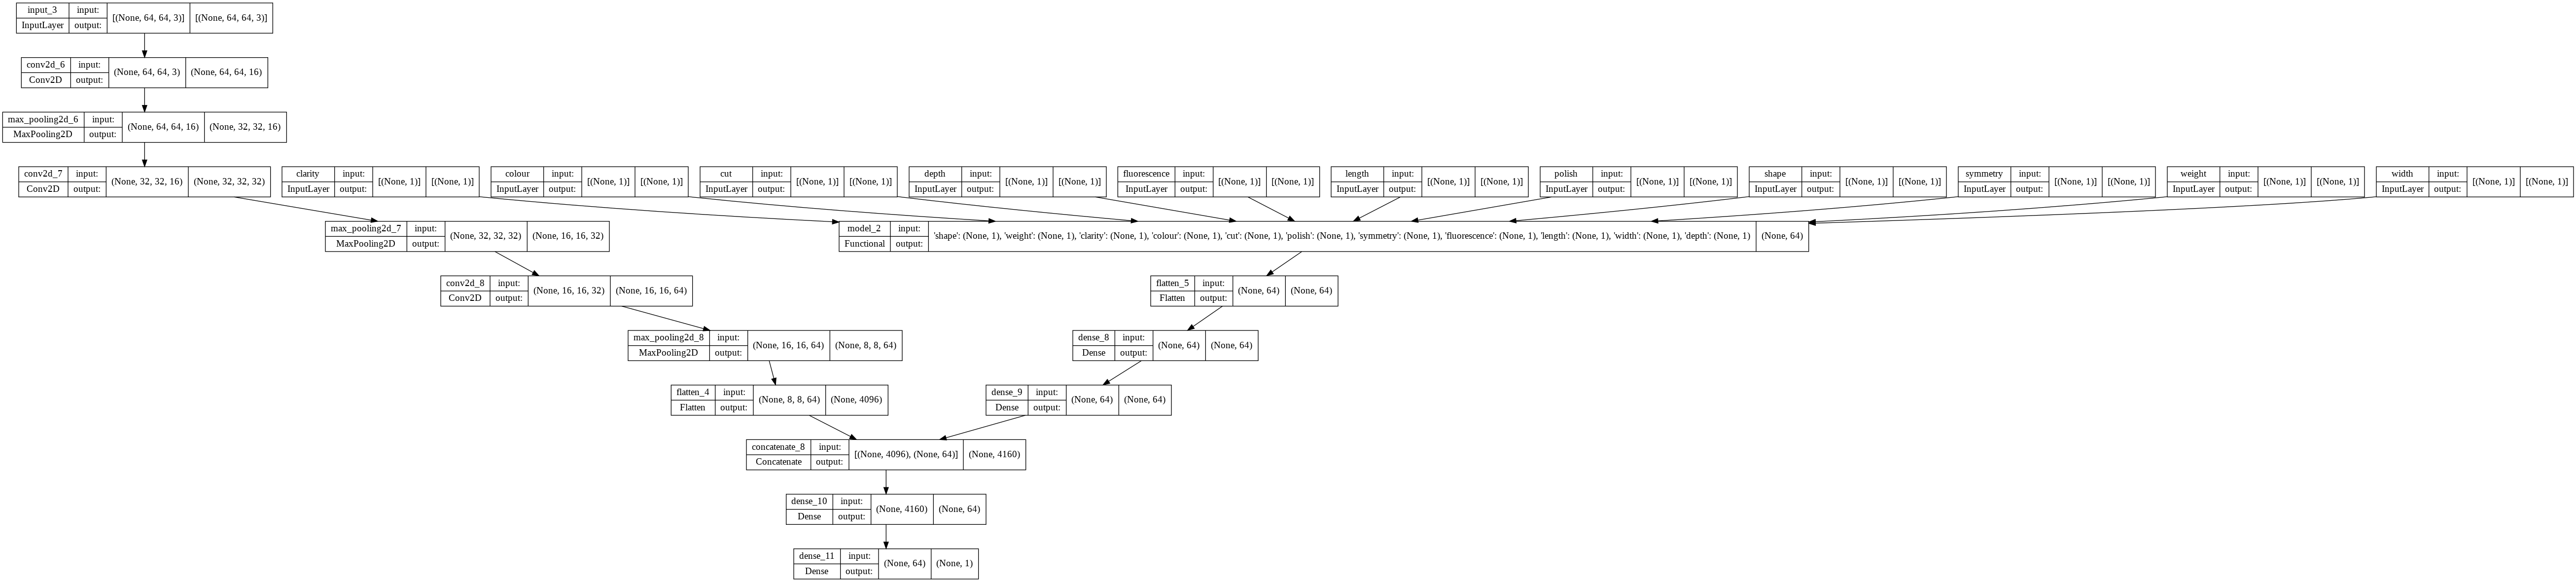

In [130]:
plot_model(model, show_shapes=True)

In [131]:
es = EarlyStopping(patience=3, restore_best_weights=True)

In [132]:
model.fit(train_dataset, epochs=100, verbose=1, callbacks=[es], validation_data=val_dataset)

Epoch 1/100
38/38 [==============================] - 12s 273ms/step - loss: 603591.7500 - mae: 609.0311 - val_loss: 180800.4531 - val_mae: 226.9256
Epoch 2/100
38/38 [==============================] - 10s 263ms/step - loss: 159171.6719 - mae: 258.3264 - val_loss: 142929.8125 - val_mae: 236.8028
Epoch 3/100
38/38 [==============================] - 10s 263ms/step - loss: 112146.4766 - mae: 209.3630 - val_loss: 73756.3281 - val_mae: 188.7301
Epoch 4/100
38/38 [==============================] - 10s 262ms/step - loss: 49870.6133 - mae: 137.6100 - val_loss: 38263.1875 - val_mae: 120.9038
Epoch 5/100
38/38 [==============================] - 10s 263ms/step - loss: 34215.2578 - mae: 113.6045 - val_loss: 31958.4004 - val_mae: 103.3085
Epoch 6/100
38/38 [==============================] - 10s 262ms/step - loss: 29263.5195 - mae: 102.0360 - val_loss: 27112.3008 - val_mae: 93.7581
Epoch 7/100
38/38 [==============================] - 10s 263ms/step - loss: 25932.2773 - mae: 97.0106 - val_loss: 25966.